<a href="https://colab.research.google.com/github/AilingLiu/Growth_Analysis/blob/master/Customer_Segmentation_From_RFM_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")

In [48]:
data_url = 'https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/online_retail.csv?raw=true'

online = pd.read_csv(data_url, encoding='unicode_escape', dtype={'InvoiceNo': object, 'CustomerID': object}, parse_dates=['InvoiceDate'], infer_datetime_format=True)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [49]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [50]:
online.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [51]:
# drop the rows whose unit price or quantity is negative

inds = online.index[(online['Quantity']<0)|(online['UnitPrice']<0)].tolist()
online = online.drop(index=inds, axis=0)
online.describe()

,Quantity,UnitPrice
count,531283.000000,531283.000000
mean,10.655299,3.898954
std,156.830617,35.876279
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


# Assign daily acquisition cohort, monthly acquisition cohort

In [52]:
import datetime as dt

def get_day(x):
  return dt.datetime(x.year, x.month, x.day) 

online['InvoiceDay'] = online['InvoiceDate'].apply(get_day)
grouping = online.groupby('CustomerID')['InvoiceDay'] 
online['CohortDay'] = grouping.transform('min')
online['CohortMonth'] = online['CohortDay'].dt.to_period('M')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12


In [53]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['DayCohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
online['MonthCohortIndex'] = years_diff*12 + months_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortMonth,DayCohortIndex,MonthCohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1.0,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1.0,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1.0,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1.0,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1.0,1.0


# Daily Retention Rate by Monthly Cohort

In [7]:
grouping = online.groupby(['CohortMonth', 'DayCohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='DayCohortIndex', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:,0]
daily_retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)*100
daily_retention

DayCohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,...,335.0,336.0,337.0,338.0,339.0,340.0,341.0,342.0,343.0,344.0,345.0,346.0,347.0,348.0,349.0,350.0,351.0,352.0,353.0,354.0,355.0,356.0,357.0,358.0,359.0,360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,370.0,371.0,372.0,373.0,374.0
CohortMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-12,100.0,3.0,2.1,1.7,2.7,3.3,3.9,5.2,5.4,2.0,1.9,1.9,3.0,3.2,2.2,2.7,0.5,0.4,0.3,1.5,0.5,0.3,0.7,0.2,0.2,0.5,0.4,0.7,0.5,0.5,0.4,1.4,1.7,2.0,1.8,1.3,1.8,0.9,2.1,4.3,...,2.5,3.3,4.5,3.7,2.0,1.7,3.0,3.4,3.8,5.0,2.6,2.7,2.4,2.7,3.1,4.4,5.4,3.7,3.0,2.4,2.6,3.7,4.0,5.5,4.0,2.5,1.1,2.7,2.8,2.2,5.0,3.5,2.6,1.2,1.6,1.1,1.8,1.1,1.1,0.5
2011-01,100.0,1.4,1.7,2.4,1.9,0.7,1.4,2.1,1.7,1.4,1.4,1.4,0.7,0.7,1.4,1.0,0.5,1.7,1.0,1.0,2.1,1.0,1.2,1.0,0.5,0.7,1.2,2.1,0.5,0.5,1.2,1.4,1.9,0.2,1.0,1.4,1.2,1.4,0.7,1.0,...,0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02,100.0,1.1,0.5,1.6,0.5,1.8,1.6,2.4,2.6,2.4,1.8,2.1,0.8,1.3,0.8,1.1,0.8,0.3,0.8,1.3,1.1,0.3,0.8,1.3,0.5,0.8,1.1,0.5,0.3,0.5,1.8,0.8,0.8,1.1,0.8,0.3,1.8,0.3,1.3,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03,100.0,0.9,1.6,0.9,2.5,1.4,0.9,2.5,0.5,0.5,0.7,0.5,0.2,1.4,0.7,0.7,0.2,0.9,1.4,1.6,1.4,1.8,1.4,NaN,0.7,1.1,0.7,0.9,0.5,1.8,0.5,0.7,0.5,0.7,0.7,0.9,1.1,NaN,0.5,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04,100.0,1.3,3.0,1.0,1.3,1.3,2.7,2.3,2.0,0.7,1.7,0.3,1.3,1.0,1.0,NaN,1.7,1.0,0.7,1.0,NaN,1.0,1.0,0.3,1.0,0.7,NaN,1.3,0.3,1.0,0.3,0.7,2.0,1.3,1.7,1.0,1.3,0.3,1.3,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05,100.0,2.9,1.4,NaN,2.2,2.2,2.2,2.2,0.7,0.4,1.1,1.4,1.8,1.8,2.5,1.1,0.7,0.4,0.4,1.8,1.1,1.8,0.7,1.4,0.7,1.1,0.7,1.1,0.7,0.4,0.7,1.4,1.1,0.7,3.2,0.4,0.4,0.7,NaN,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,2.6,2.1,0.4,2.6,1.7,0.9,0.9,2.6,0.9,0.9,0.9,0.4,0.4,0.9,1.3,0.9,2.6,0.9,0.4,0.4,2.1,0.9,0.4,NaN,0.9,0.4,1.3,1.7,0.9,0.9,0.9,0.9,0.4,0.9,NaN,0.9,0.9,0.9,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,1.0,NaN,1.6,1.6,1.0,0.5,1.0,0.5,1.6,1.6,0.5,1.6,NaN,2.6,NaN,1.6,0.5,0.5,NaN,1.6,1.6,0.5,0.5,1.6,1.0,2.6,1.0,1.0,0.5,1.0,0.5,0.5,1.0,0.5,0.5,NaN,0.5,2.1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,NaN,1.8,2.4,1.2,1.8,0.6,NaN,0.6,1.8,1.8,NaN,1.2,3.0,1.2,1.8,NaN,1.2,1.2,1.2,1.8,0.6,1.2,1.8,NaN,NaN,1.2,1.2,0.6,0.6,1.2,1.8,1.2,1.8,1.2,NaN,1.8,NaN,NaN,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Monthly Retention by Monthly Cohort

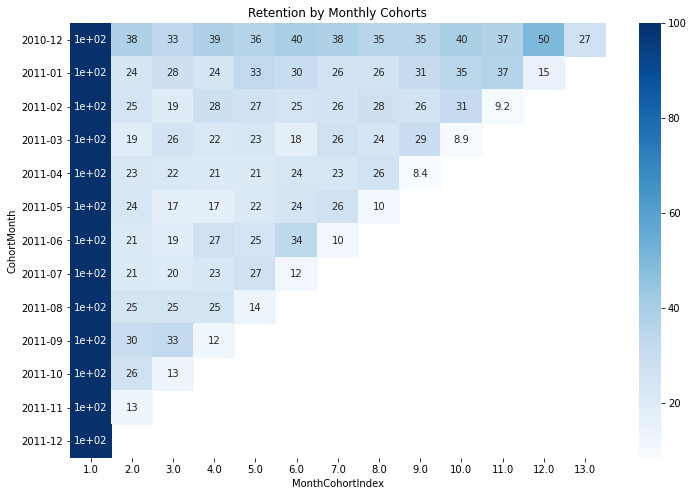

In [8]:
grouping = online.groupby(['CohortMonth', 'MonthCohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='MonthCohortIndex', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:,0]
monthly_retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)*100

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(monthly_retention, annot=True, cmap='Blues', ax=ax)
ax.set(title='Retention by Monthly Cohorts')
plt.show()

# Average Spend Per Invoice by Monthly Cohort

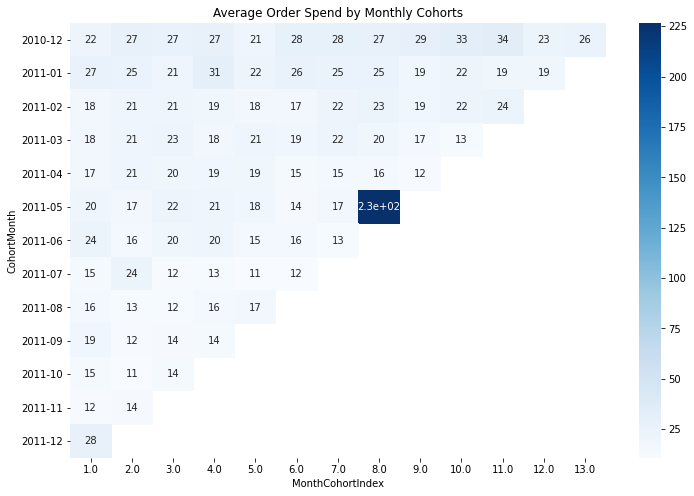

In [54]:
online['Order_total'] = online['UnitPrice']*online['Quantity']
grouping = online.groupby(['CohortMonth', 'MonthCohortIndex']) 
cohort_data = grouping['Order_total'].mean()
cohort_data = cohort_data.reset_index()
average_spend = cohort_data.pivot(index='CohortMonth', columns='MonthCohortIndex', values='Order_total').round(1)

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(average_spend, annot=True, cmap='Blues', ax=ax)
ax.set(title='Average Order Spend by Monthly Cohorts')
plt.show()

# Create RFM Value, Scores, and Segment

RFM refers to Recency, Frequency, and Monetary Value. In this project, recency means how many days have past since the last order from each customer; frequency means how many orders (invoices id) have the customer placed so far; finally, monetary means the total spend from customers.

The RFM values can be grouped in several ways:

* Percentiles e.g. quantiles
* Pareto 80/20 cut
* Custom - based on business knowledge

Assigning labels to each quantile:

- Highest score to the best metric - best is not always highest e.g. recency
- In this case, the label is inverse - the more recent the customer, the better

For recency calculation, we will need to define a snapshot date as the cut off date for our analysis.

### RFM Value

In [55]:
snapshot_date = online['InvoiceDate'].max() + dt.timedelta(days=1) #the next date of the latest date in the record
print(f'Snapshot date: {snapshot_date}')

datamart = online.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                             'InvoiceNo': 'nunique',
                                             'Order_total': 'sum'})

datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Order_total': 'MonetaryValue'}, inplace=True)

datamart.head(3)

Snapshot date: 2011-12-10 12:50:00


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24


In [0]:
?datamart.describe()

In [65]:
#datamart['Frequency'].describe(percentiles=[.33, .33, .33])
pd.qcut(datamart['Frequency'].rank(method='first'), 3)

CustomerID
12346     (0.999, 1447.0]
12347    (2893.0, 4339.0]
12348    (1447.0, 2893.0]
12349     (0.999, 1447.0]
12350     (0.999, 1447.0]
               ...       
18280    (1447.0, 2893.0]
18281    (1447.0, 2893.0]
18282    (1447.0, 2893.0]
18283    (2893.0, 4339.0]
18287    (1447.0, 2893.0]
Name: Frequency, Length: 4339, dtype: category
Categories (3, interval[float64]): [(0.999, 1447.0] < (1447.0, 2893.0] < (2893.0, 4339.0]]

### RFM Score

Here, we will group RFM values into three equal percentile groups, assigned with labels. The highest label to the best metric.

In [69]:
r_labels = range(3, 0, -1)
f_labels = range(1, 4)
m_labels = range(1, 4)

r_groups = pd.qcut(datamart['Recency'], q=3, labels=r_labels)
f_groups = pd.qcut(datamart['Frequency'].rank(method='first'), q=3, labels=f_labels)
m_groups = pd.qcut(datamart['MonetaryValue'], q=3, labels=m_labels)

datamart = datamart.assign(R=r_groups, F=f_groups, M=m_groups)

# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
datamart['RFM_Score'].head()

CustomerID
12346    5.0
12347    9.0
12348    7.0
12349    7.0
12350    3.0
Name: RFM_Score, dtype: float64

### RFM Segment

In [70]:
def rfm_segment(row):
  return str(row['R']) + str(row['F']) + str(row['M'])

def rfm_level(df):
    if df['RFM_Score'] >= 8:
        return 'Top'
    elif ((df['RFM_Score'] >=5) and (df['RFM_Score'] < 8)):
        return 'Middle'
    else:
        return 'Low'

datamart['RFM_Segment'] = datamart.apply(rfm_segment, axis=1)
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment,RFM_Level
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,3,5.0,113,Middle
12347,2,7,4310.00,3,3,3,9.0,333,Top
12348,75,4,1797.24,2,2,3,7.0,223,Middle
12349,19,1,1757.55,3,1,3,7.0,313,Middle
12350,310,1,334.40,1,1,1,3.0,111,Low


### Analysis on RFM segment

In [71]:
datamart.groupby('RFM_Score').agg({'Recency':'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count']})

Recency  Frequency MonetaryValue      
                 mean       mean          mean count
RFM_Score                                           
3.0        245.011164   1.000000    201.150861   627
4.0        140.190244   1.261789    322.693480   615
5.0        102.484672   1.715328    663.666366   685
6.0         68.739203   2.506645    982.647894   602
7.0         45.824197   3.538752   1332.113953   529
8.0         33.596774   5.910394   2830.660878   558
9.0          9.719225  12.834025   7270.355851   723

In [72]:
datamart.groupby('RFM_Segment').agg({'Recency':'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count']}).sort_index(ascending=False)

Recency  Frequency MonetaryValue      
                   mean       mean          mean count
RFM_Segment                                           
333            9.719225  12.834025   7270.355851   723
332           12.471831   4.802817    865.100704   142
331           11.000000   5.200000    257.886000     5
323           13.855422   2.939759   4338.025783    83
322           13.215190   2.527426    718.752447   237
321           13.152381   2.123810    268.881333   105
313           11.000000   1.000000   2273.346667     3
312           16.114286   1.000000    581.664000    35
311           14.787879   1.000000    209.644470   132
233           47.525526   7.123123   3293.118108   333
232           48.366337   4.811881    841.009020   101
231           59.333333   4.166667    265.230000     6
223           53.557522   2.796460   2252.807168   113
222           53.260726   2.422442    730.082149   303
221           52.800000   2.086957    266.309217   115
213           63.950000   1.000000   2187.797000    20
212           59.131034   1.000000    606.505731   145
211           54.740614   1.000000    214.026962   293
133          144.057143   6.314286   2667.505143    70
132          158.983051   4.728814    788.047288    59
131          197.571429   4.714286    227.511429     7
123          165.986486   2.608108   3106.841230    74
122          178.011583   2.308880    693.689923   259
121          203.133758   2.025478    249.381274   157
113          226.518519   1.000000   4707.823333    27
112          232.036364   1.000000    585.416545   165
111          245.011164   1.000000    201.150861   627

In [73]:
datamart.groupby('RFM_Level').agg({'Recency':'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count']}).sort_index(ascending=False)

Recency Frequency MonetaryValue      
                 mean      mean          mean count
RFM_Level                                          
Top         20.120219  9.818111   5336.437198  1281
Middle      74.792952  2.508811    964.126528  1816
Low        193.107085  1.129630    261.335008  1242

# K means clustering customers

assumptions to be met before applying k means
- normally distributed
- each feature has similar mean and std

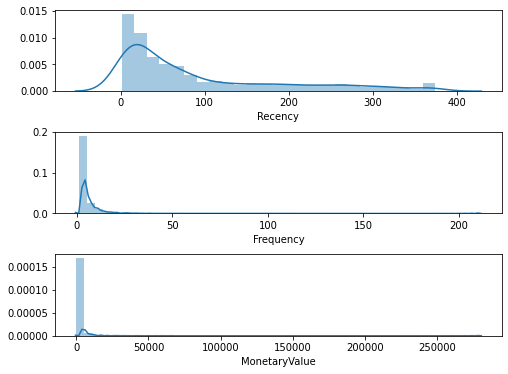

In [74]:
#check assumptions by visualising RFM features
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1); sns.distplot(datamart['Recency'])
plt.subplot(3, 1, 2); sns.distplot(datamart['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(datamart['MonetaryValue'])
plt.subplots_adjust(hspace=0.5)
plt.show()

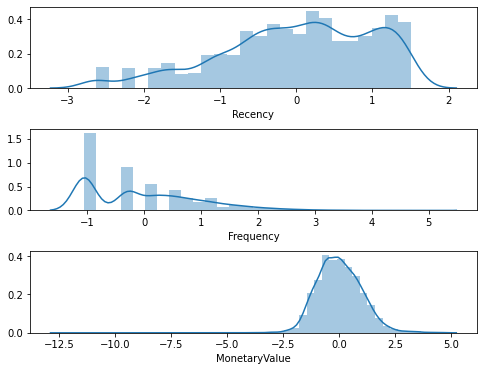

In [77]:
#unskew data

datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]
datamart_log = np.log(datamart_rfm+0.0001) #get rid of inf trouble when value is 0

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_normalized = scaler.transform(datamart_log)
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

# Plot to check
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])
plt.subplots_adjust(hspace=0.5)
plt.show()

## Run k means

In [80]:
## build 3 clusters to start with
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=1) 
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_

datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)
grouped = datamart_rfm_k3.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1).sort_values(by=[('Recency', 'mean')], ascending=True)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
1          13.3      12.9        7500.9   798
0          54.2       3.5        1352.6  1702
2         162.4       1.3         339.1  1839

## Use elbow method to choose best k

In [0]:
sse={}

for k in range(1, 21):
  
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_

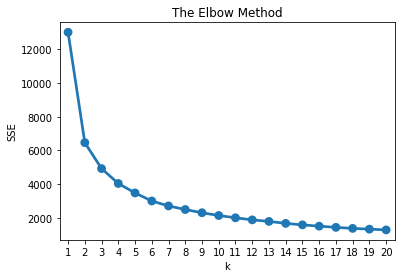

In [84]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

The elbow is located at 2. We will choose 3 as it contains more information in RFM value.

In [89]:
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_

datamart_rfm_k2 = datamart_rfm.assign(Cluster=cluster_labels)
grouped = datamart_rfm_k2.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1).sort_values(by=[('Recency', 'mean')], ascending=True)
  

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
1          27.9       8.2        4368.0  1762
0         136.7       1.6         471.5  2577

## Segment profiling 

* use snake plot
* relative importance of each attribute

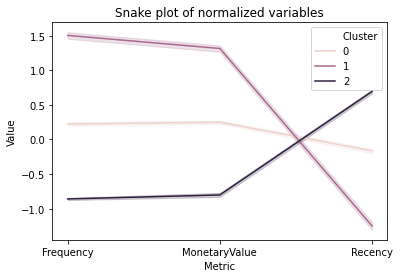

In [94]:
datamart_normalized = datamart_normalized.assign(Cluster=datamart_rfm_k3['Cluster'].values)

datamart_melt = pd.melt(
  					datamart_normalized.reset_index(),
            id_vars=['CustomerID', 'Cluster'],
            value_vars=['Recency', 'Frequency', 'MonetaryValue'],
            var_name='Metric', value_name='Value')

plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

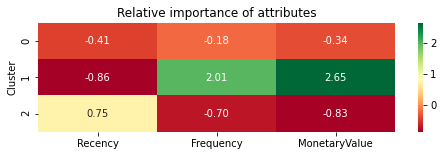

In [97]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

The further a ratio is from 0, the more important that attribute is for a segment relative to the total population. Here, we can see 'frequency' and 'monetary value' in cluster 1 have higher importance relative to general population.